## Task 2: Sentiment and Thematic Analysis

### 2.1 Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import os

In [41]:
# ---  Data Loading ---
try:
    df = pd.read_csv('../data/processed/reviews_processed.csv')
    print("Successfully loaded 'reviews_processed.csv'")
except FileNotFoundError:
    print("WARNING: Data file not found. Please ensure data is in '../data/processed/'.")


Successfully loaded 'reviews_processed.csv'


In [3]:
# ---  SENTIMENT ANALYSIS (TextBlob) ---

# Lexicon-based sentiment with TextBlob
# Polarity in [-1, 1], subjectivity in [0, 1]

# Get polarity and subjectivity
df["tb_polarity"] = df["review_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
df["tb_subjectivity"] = df["review_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Convert polarity → sentiment label
def polarity_to_label(p):
    if p > 0.1:
        return "positive"
    elif p < -0.1:
        return "negative"
    else:
        return "neutral"

df["tb_sentiment"] = df["tb_polarity"].apply(polarity_to_label)

# Show output
df[["review_text", "rating", "tb_polarity", "tb_subjectivity", "tb_sentiment"]]


,review_text,rating,tb_polarity,tb_subjectivity,tb_sentiment
0,bad exprience...it is so crushed,1,-0.400000,0.383333,negative
1,not user friendly at all it requires a huge co...,1,0.425000,0.633333,positive
2,most of the time is not working properly,1,0.250000,0.300000,positive
3,It keeps notifying me to disable developer opt...,1,0.068182,0.393939,neutral
4,the lag is unbelievable when you need it the m...,1,0.125000,0.750000,positive
...,...,...,...,...,...
1190,mobile banking to the next level,5,0.000000,0.000000,neutral
1191,The first 3 star review is me,3,0.250000,0.333333,positive
1192,"Fast, reliable and user friendly. Amazing chat...",5,0.504167,0.666667,positive
1193,This app is literally the best thing ever The ...,5,0.345833,0.493750,positive


In [4]:
# --- SENTIMENT ANALYSIS (VADER) ---
#  Download VADER lexicon for sentiment analysis (only first time)
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to C:\Users\MUHAJER
[nltk_data]     HUALIS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
# Lexicon-based sentiment with VADER
# VADER is optimized for reviews, slang, emojis, and short texts

def vader_compound(text):
    return sia.polarity_scores(text)["compound"]

# VADER compound score
df["vader_compound"] = df["review_text"].apply(vader_compound)

# Convert compound score → sentiment label
# Standard VADER rule:
# compound >= 0.05 → positive
# compound <= -0.05 → negative
# otherwise → neutral

def vader_label(c):
    if c >= 0.05:
        return "positive"
    elif c <= -0.05:
        return "negative"
    else:
        return "neutral"

df["vader_sentiment"] = df["vader_compound"].apply(vader_label)

# Show output
df[["review_text", "rating", "tb_polarity", "vader_compound", "vader_sentiment"]]


,review_text,rating,tb_polarity,vader_compound,vader_sentiment
0,bad exprience...it is so crushed,1,-0.400000,-0.7973,negative
1,not user friendly at all it requires a huge co...,1,0.425000,-0.4268,negative
2,most of the time is not working properly,1,0.250000,0.0000,neutral
3,It keeps notifying me to disable developer opt...,1,0.068182,-0.4019,negative
4,the lag is unbelievable when you need it the m...,1,0.125000,-0.1531,negative
...,...,...,...,...,...
1190,mobile banking to the next level,5,0.000000,0.0000,neutral
1191,The first 3 star review is me,3,0.250000,0.0000,neutral
1192,"Fast, reliable and user friendly. Amazing chat...",5,0.504167,0.8217,positive
1193,This app is literally the best thing ever The ...,5,0.345833,0.9279,positive


Visualization of lexicon scores vs rating

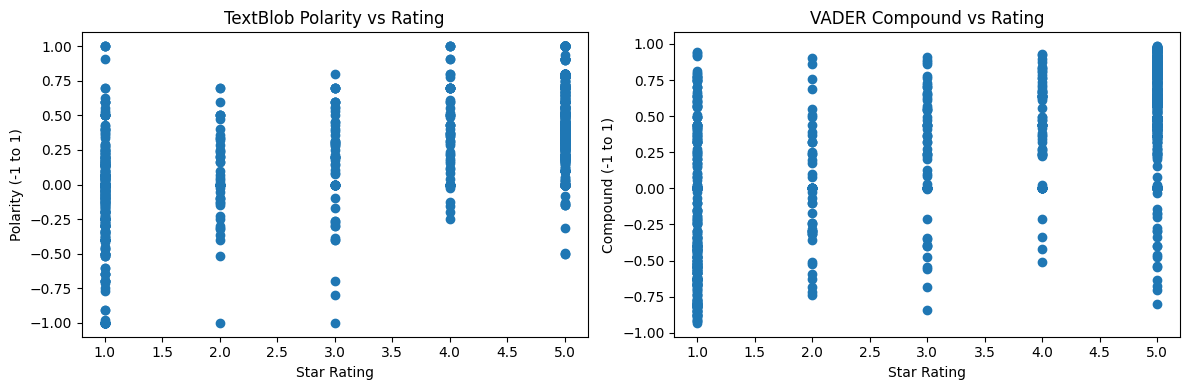

In [6]:
# See how lexicon scores correlate with star rating

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(df["rating"], df["tb_polarity"])
axes[0].set_title("TextBlob Polarity vs Rating")
axes[0].set_xlabel("Star Rating")
axes[0].set_ylabel("Polarity (-1 to 1)")

axes[1].scatter(df["rating"], df["vader_compound"])
axes[1].set_title("VADER Compound vs Rating")
axes[1].set_xlabel("Star Rating")
axes[1].set_ylabel("Compound (-1 to 1)")

plt.tight_layout()
plt.show()


### 2.2 Thematic Analysis

Keyword Extraction & Manual/Rule-Based Clustering:

In [ ]:
# --- THEMATIC ANALYSIS SETUP (TF-IDF) ---

import re

# Simple preprocessing for TF-IDF 
def preprocess_text(text):
   # lower-casing
    text = text.lower() 
        
    # Remove digits, URLs, excessive punctuation
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)  # keep only alphanum + space
    text = re.sub(r'\s+', ' ', text).strip()
    return text


df['cleaned_review'] = df['review_text'].apply(preprocess_text)



In [8]:
# Initialize TF-IDF Vectorizer

tfidf_vec = TfidfVectorizer(stop_words="english", ngram_range = (1,2))
X_tfidf = tfidf_vec.fit_transform(df["cleaned_review"])

# Get average TF-IDF score per word across documents
tfidf_means = np.asarray(X_tfidf.mean(axis=0)).flatten()
vocab_tfidf = np.array(tfidf_vec.get_feature_names_out())

tfidf_df = pd.DataFrame({"word": vocab_tfidf, "tfidf": tfidf_means})
tfidf_df = tfidf_df.sort_values("tfidf", ascending=False)
tfidf_df.head(10)


,word,tfidf
363,app,0.058422
3629,good,0.037705
1235,best,0.029057
3632,good app,0.023074
971,bank,0.020464
8087,use,0.016874
1089,banking,0.016424
2667,easy,0.015575
3719,great,0.014749
3139,fast,0.014139


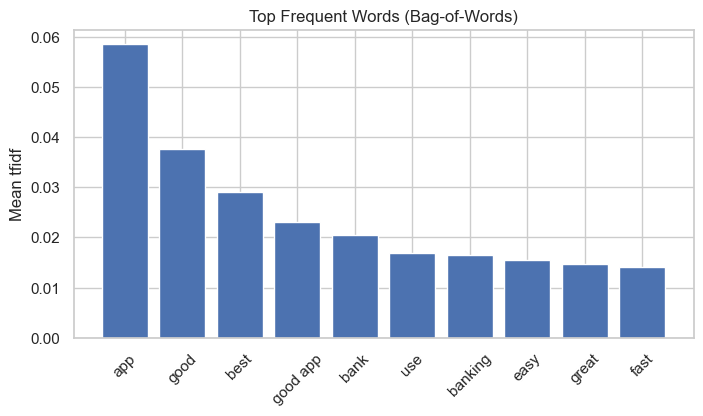

In [52]:
top_n = 10
top_freq = tfidf_df.head(top_n)

plt.bar(top_freq["word"], top_freq["tfidf"])
plt.xticks(rotation=45)
plt.title("Top Frequent Words (Bag-of-Words)")
plt.ylabel("Mean tfidf")
plt.show()


-> > 0.10 = very important

-> 0.05–0.10 = meaningful

-> < 0.05 = low importance `

Topic Modeling (LDA)

In [9]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

# Tokenize text 
df["tokens"] = df["cleaned_review"].str.split()

# Create dictionary and corpus for LDA
dictionary = Dictionary(df["tokens"])
corpus = [dictionary.doc2bow(tokens) for tokens in df["tokens"]]


In [10]:
import nltk
from nltk.corpus import stopwords

# Download stopwords (only first time)
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))
# Remove stopwords from your tokenized text
df["tokens_nostop"] = df["tokens"].apply(
    lambda words: [w for w in words if w not in stop_words]
)

df[["cleaned_review", "tokens", "tokens_nostop"]].head()


[nltk_data] Downloading package stopwords to C:\Users\MUHAJER
[nltk_data]     HUALIS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,cleaned_review,tokens,tokens_nostop
0,bad exprience it is so crushed,"[bad, exprience, it, is, so, crushed]","[bad, exprience, crushed]"
1,not user friendly at all it requires a huge co...,"[not, user, friendly, at, all, it, requires, a...","[user, friendly, requires, huge, connectivity,..."
2,most of the time is not working properly,"[most, of, the, time, is, not, working, properly]","[time, working, properly]"
3,it keeps notifying me to disable developer opt...,"[it, keeps, notifying, me, to, disable, develo...","[keeps, notifying, disable, developer, options..."
4,the lag is unbelievable when you need it the m...,"[the, lag, is, unbelievable, when, you, need, ...","[lag, unbelievable, need, suks]"


In [11]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
# Use stopword-cleaned tokens
dictionary = Dictionary(df["tokens_nostop"])
corpus = [dictionary.doc2bow(tokens) for tokens in df["tokens_nostop"]]


lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=4,
    passes=10,
    random_state=42
)

topics = lda_model.show_topics(num_topics=4, num_words=10, formatted=False)

for i, topic in topics:
    print(f"\n--- Topic {i+1} ---")
    for word, weight in topic:
        print(f"{word:15s}  weight={weight:.4f}")



--- Topic 1 ---
app              weight=0.0854
bank             weight=0.0237
banking          weight=0.0216
best             weight=0.0209
dashen           weight=0.0207
use              weight=0.0195
easy             weight=0.0163
super            weight=0.0154
one              weight=0.0134
fast             weight=0.0132

--- Topic 2 ---
bank             weight=0.0220
app              weight=0.0210
working          weight=0.0162
money            weight=0.0154
please           weight=0.0123
cbe              weight=0.0119
boa              weight=0.0106
account          weight=0.0097
transfer         weight=0.0094
even             weight=0.0079

--- Topic 3 ---
app              weight=0.0612
good             weight=0.0401
banking          weight=0.0112
bank             weight=0.0102
update           weight=0.0094
mobile           weight=0.0085
service          weight=0.0083
work             weight=0.0074
one              weight=0.0066
application      weight=0.0059

--- Topic 4 ---
ap

Rule-Based Thematic Grouping Per Bank

In [17]:
from sklearn.decomposition import LatentDirichletAllocation


def get_topics_for_bank(df_bank, n_topics=4, top_n=12):
    # Filter very short reviews
    docs = df_bank[df_bank['cleaned_review'].str.len() > 10]['cleaned_review'].tolist()
    if len(docs) < 50:
        return []

    # Vectorize with stricter settings
    tfidf = TfidfVectorizer(
        max_df=0.85,      # ignore words in >85% docs
        min_df=3,         # ignore words in <3 docs
        ngram_range=(1,2),
        stop_words='english',
        max_features=800,
        token_pattern=r'\b[a-zA-Z]{3,}\b'  # only words ≥3 chars

    )
    X = tfidf.fit_transform(docs)
    
    lda = LatentDirichletAllocation(
        n_components=n_topics, 
        random_state=42,
        learning_method='online'
    )
    lda.fit(X)
    
    feature_names = tfidf.get_feature_names_out()
    topics = []
    for i, comp in enumerate(lda.components_):
        top_idx = comp.argsort()[-top_n:][::-1]
        top_words = [(feature_names[j], comp[j]) for j in top_idx]
        topics.append(top_words)
    return topics

In [16]:
for bank in ['Commercial Bank of Ethiopia', 'Bank of Abyssinia', 'Dashen Bank']:
    df_bank = df[df['bank_name'] == bank]
    topics = get_topics_for_bank(df_bank)
    print(f"\n=== {bank} ===")
    for i, topic in enumerate(topics):
        words = [w for w, _ in topic[:10]]
        print(f"Topic {i+1}: {', '.join(words)}")


=== Commercial Bank of Ethiopia ===
Topic 1: app, bank, good app, banking, good, transaction, history, mobile, mobile banking, ethiopia
Topic 2: best, good, application, app, fast, service, useful, add, best application, apps
Topic 3: app, use, easy, easy use, nice, life, money, problem, nice app, make
Topic 4: cbe, excellent, time, user, works, application, work, friendly, bank, improve

=== Bank of Abyssinia ===
Topic 1: app, best, easy, fast, worest, worest app, best app, disappointing, use, error
Topic 2: app, worst, banking, mobile, working, worst app, doesn, work, mobile banking, doesn work
Topic 3: good, works, update, better, app, really, needs, work, service, money
Topic 4: bank, good, app, bad, slow, good app, application, good application, don, abyssinia

=== Dashen Bank ===
Topic 1: use, easy, app, slow, easy use, application, transaction, dashen, super, bank
Topic 2: bank, app, good, working, account, nice, option, app good, thanks, send
Topic 3: app, best, dashen, user, 

In [18]:
THEME_MAPPING = {
    'ui-ux': ['easy', 'user friendly', 'interface', 'design', 'layout', 'smooth'],
    'performance': ['slow', 'lag', 'loading', 'freeze', 'hang', 'delay'],
    'core-functionality': ['login', 'otp', 'transfer', 'balance', 'transaction', 'authentication'],
    'user-sentiment': ['worst', 'frustrated', 'disappointed', 'hate', 'terrible', 'fix'],
    'feature-requests': ['add', 'include', 'wish', 'hope', 'should have', 'dark mode', 'fingerprint']
}

In [31]:
def assign_themes(text, mapping, top_k=1):
    text = text.lower()
    scores = {}
    for theme, keywords in mapping.items():
        score = sum(1 for kw in keywords if kw in text)
        if score > 0:
            scores[theme] = score
    # Return top-k themes
    return ', '.join(sorted(scores, key=scores.get, reverse=True)[:top_k]) or 'other'

df['theme'] = df['review_text'].apply(lambda x: assign_themes(x, THEME_MAPPING))

In [32]:
theme_sentiment = df.groupby('theme')['vader_compound'].agg(['mean', 'count']).sort_values('mean')
print(theme_sentiment)

                        mean  count
theme                              
user-sentiment     -0.417632     76
performance        -0.054321     76
core-functionality  0.139479    106
other               0.281353    768
feature-requests    0.351479     28
ui-ux               0.656111    141


In [33]:
output_df = df[[
    'review_id', 'review_text', 'vader_sentiment', 'vader_compound', 'theme'
]].rename(columns={
    'vader_sentiment': 'sentiment_label',
    'vader_compound': 'sentiment_score'
})
output_df.to_csv('../data/processed/reviews_with_themes.csv', index=False)

<Axes: xlabel='bank_name'>

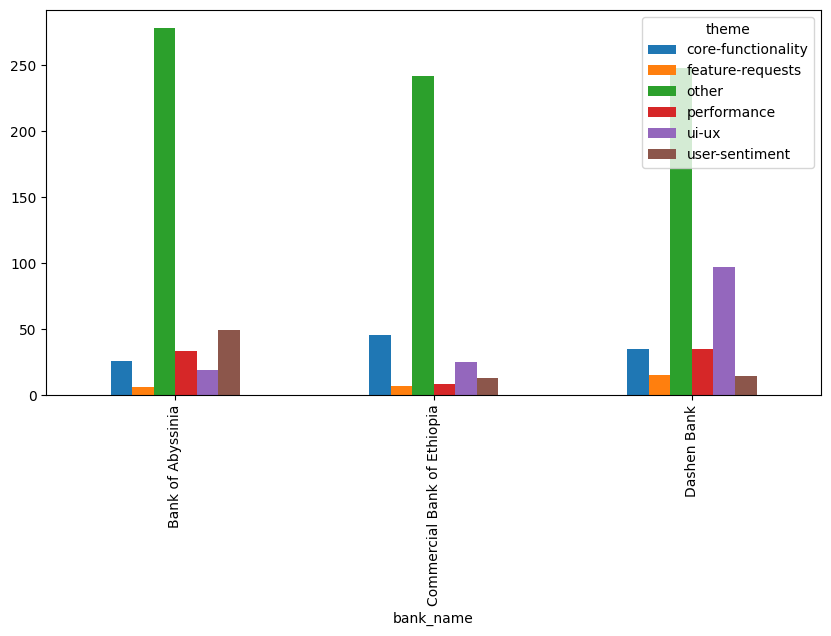

In [34]:
pd.crosstab(df['bank_name'], df['theme']).plot(kind='bar', figsize=(10,5))